### Notebook 5 — Cost-Aware Model Router Training

This notebook trains a machine learning router that selects the most cost-efficient AI model capable of meeting performance and latency requirements.

Using model capability profiles and synthetic request generation, the router learns to assign requests to optimal models under operational constraints.

The trained router is evaluated against baseline strategies to measure cost savings and service-level performance.

The routing model is trained on synthetic workloads to approximate real-world inference demand patterns. Model selection is treated as a constrained optimization problem balancing latency, quality, and cost.


In [2]:
import sys
import boto3
import numpy as np
import pandas as pd
import sagemaker
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import joblib

Unable to load JumpStart region config.
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.12/site-packages/sagemaker/jumpstart/constants.py", line 69, in _load_region_config
    with open(filepath) as f:
         ^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/home/ec2-user/anaconda3/envs/python3/lib/python3.12/site-packages/sagemaker/jumpstart/region_config.json'


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### Configure Environment and Verify Dependencies

Initialize SageMaker session, identify the project S3 bucket, and verify required packages for data access.

In [3]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
print("Python:", sys.version)
print("Bucket:", bucket)

Python: 3.12.12 | packaged by conda-forge | (main, Jan 26 2026, 23:51:32) [GCC 14.3.0]
Bucket: sagemaker-us-east-1-907086662522


In [4]:
# Check if s3fs exists
try:
    import s3fs
    print("s3fs installed ✅")
except Exception as e:
    print("s3fs missing ❌", e)

s3fs installed ✅


In [5]:
# Confirm the file exists in S3
!aws s3 ls s3://{bucket}/processed/

2026-02-22 23:20:31       1769 model_profiles.csv
2026-02-23 01:47:51        334 router_alt_xgboost_results.csv
2026-02-22 23:23:00    2667107 synthetic_requests_labeled_v2.csv


### Load Model Capability Profiles

Load aggregated model performance profiles generated in Notebook 4.

These profiles contain model quality tiers and capability metrics used to simulate routing decisions.

In [6]:
s3 = boto3.client("s3")
try:
    s3.head_object(Bucket=bucket, Key="processed/model_profiles.csv")
    print("model_profiles.csv found in S3 ✅")
except:
    raise FileNotFoundError("model_profiles.csv not found in S3. Run Notebook 4 first.")

model_profiles.csv found in S3 ✅


In [7]:
sess = sagemaker.Session()
bucket = sess.default_bucket()

profiles = pd.read_csv(f"s3://{bucket}/processed/model_profiles.csv")
print("profiles shape:", profiles.shape)
print(profiles.columns.tolist())
display(profiles.head(10))

/home/ec2-user/anaconda3/envs/python3/lib/python3.12/site-packages/fsspec/registry.py:301: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


profiles shape: (17, 9)
['Model', 'quality_score_mean', 'quality_score_max', 'achievements_count', 'domains_count', 'peer_reviewed_rate', 'outperforms_rate', 'domains_covered', 'quality_tier']


,Model,quality_score_mean,quality_score_max,achievements_count,domains_count,peer_reviewed_rate,outperforms_rate,domains_covered,quality_tier
0,Gemini 3,4.476880,4.476880,1,1,0.0,1.0000,Transcription,5
1,Claude 3.6S,4.415792,4.415792,1,1,0.0,1.0000,Persuasion,5
2,o3-mini-high,4.360643,4.360643,1,1,0.0,1.0000,Health reviews,5
3,o1,4.040036,4.500000,2,2,0.0,1.0000,"Maths, Medicine",5
4,"GPT-4, etc",3.694612,3.694612,1,1,0.0,1.0000,Emotional intelligence,4
5,o4-mini,3.614010,3.614010,1,1,0.0,1.0000,Finance,4
6,davinci,3.468992,4.000000,4,3,0.0,1.0000,"General knowledge, IQ (Binet-Simon Scale, verb...",4
7,Bing Chat,3.385513,3.703680,2,2,0.0,1.0000,"Japan: National Medical Licensure Examination,...",3
8,GPT-4.5,3.355234,3.355234,1,1,0.0,1.0000,Being human,3
9,GPT-4,2.381280,4.168894,16,15,0.0,0.9375,"Academia, Aerospace, Art (via prompting Midjou...",3


### Initialize Router Training Environment

Import machine learning libraries and prepare the environment for synthetic data generation and model training.


In [8]:
sess = sagemaker.Session()
bucket = sess.default_bucket()

# -------------------------
# Load model profiles
# -------------------------
profiles = pd.read_csv(f"s3://{bucket}/processed/model_profiles.csv")
profiles["Model"] = profiles["Model"].astype(str).str.strip()
profiles = profiles[profiles["Model"].notna() & (profiles["Model"] != "nan")].copy()

# Using top 6 models
profiles = profiles.sort_values(["quality_tier","quality_score_mean"], ascending=[False, False]).head(6).copy()
models = profiles["Model"].tolist()
print("Using models:", models)


Using models: ['Gemini 3', 'Claude 3.6S', 'o3-mini-high', 'o1', 'GPT-4, etc', 'o4-mini']


### Define Model Operational Characteristics

Assign simulated operational properties to each model, including:

- Cost per token
- Base latency
- Per-token latency

These values represent realistic infrastructure trade-offs.

In [9]:
# -------------------------
# Improved synthetic traits (wider spread)
# -------------------------
# cost rises with quality tier (more realistic)
profiles["cost_per_token"] = 0.0000006 * (1.8 ** (profiles["quality_tier"] - 1))   # bigger gap

# latency increases with quality tier but not crazy
profiles["base_latency_ms"] = 60 + 55 * (profiles["quality_tier"] - 1)            # 60..335
profiles["per_token_ms"] = 0.010 + 0.008 * (profiles["quality_tier"] - 1)         # 0.01..0.042

# quality score normalized
q = profiles["quality_score_mean"].astype(float)
profiles["quality_score_norm"] = ((q - q.min()) / (q.max() - q.min() + 1e-9)).clip(0, 1)

mp = profiles.set_index("Model")[["base_latency_ms","per_token_ms","cost_per_token","quality_score_norm","quality_tier"]].to_dict("index")
fallback_model = profiles.sort_values("quality_score_norm", ascending=False).iloc[0]["Model"]
print("Fallback model:", fallback_model)


Fallback model: Gemini 3


### Generate Synthetic Inference Requests

Simulate a diverse set of user requests with varying:

- Prompt size
- Output size
- Latency requirements
- Quality requirements

This forms the training dataset for the routing model.


In [10]:
# -------------------------
# Generate synthetic requests (rebalanced)
# -------------------------
rng = np.random.default_rng(7)
N = 40000

mix = rng.choice([0,1,2], size=N, p=[0.50,0.40,0.10])
prompt_tokens = np.where(
    mix==0, rng.integers(20, 500, size=N),
    np.where(mix==1, rng.integers(500, 2500, size=N), rng.integers(2500, 10000, size=N))
)
output_tokens = (prompt_tokens * rng.uniform(0.15,0.7,size=N) + rng.integers(20,250,size=N)).astype(int)
output_tokens = np.clip(output_tokens, 30, 3000)

domains = rng.choice(["chat","writing","code","qa","reasoning"], size=N, p=[0.28,0.20,0.18,0.20,0.14])
lat_req = rng.choice([200,400,800,1500,3000,6000], size=N, p=[0.10,0.15,0.25,0.25,0.18,0.07])

# KEY CHANGE: quality requirement is softened (more feasible competition)
# Instead of mapping tier -> 0..1, map tier -> 0.35..0.85
q_tier = rng.choice([1,2,3,4,5], size=N, p=[0.25,0.28,0.25,0.15,0.07])
q_req = 0.35 + (q_tier - 1) * (0.50/4.0)   # 0.35..0.85

requests = pd.DataFrame({
    "prompt_tokens": prompt_tokens,
    "output_tokens": output_tokens,
    "tokens_total": prompt_tokens + output_tokens,
    "domain": domains,
    "latency_requirement_ms": lat_req,
    "quality_req_tier": q_tier,
    "quality_requirement": q_req,
})
requests["log_tokens_total"] = np.log1p(requests["tokens_total"])
requests["strict_latency"] = (requests["latency_requirement_ms"] <= 400).astype(int)

# Domain penalty still matters but slightly lower so mid models can compete
domain_penalty = {"chat":0.00,"writing":0.04,"qa":0.03,"code":0.07,"reasoning":0.08}
requests["domain_penalty"] = requests["domain"].map(domain_penalty).fillna(0.05)

print("Requests:", requests.shape)
display(requests.head())


Requests: (40000, 10)


,prompt_tokens,output_tokens,tokens_total,domain,latency_requirement_ms,quality_req_tier,quality_requirement,log_tokens_total,strict_latency,domain_penalty
0,2103,1217,3320,writing,200,4,0.725,8.108021,1,0.04
1,2353,1094,3447,reasoning,3000,3,0.600,8.145550,0,0.08
2,511,475,986,chat,400,1,0.350,6.894670,1,0.00
3,204,191,395,code,800,4,0.725,5.981414,0,0.07
4,121,141,262,writing,400,3,0.600,5.572154,1,0.04


### Define Optimal Routing Policy (Training Labels)

Assign the target model for each request based on a cost-minimization rule subject to feasibility constraints.

This represents the optimal decision the router should learn.

In [11]:
# -------------------------
# Label policy: cheapest feasible model
# -------------------------
labels = []
for _, r in requests.iterrows():
    tokens = r["tokens_total"]
    long_pen = 0.08 if tokens > 4000 else 0.0

    feas = []
    for m in models:
        base = mp[m]["base_latency_ms"]
        per  = mp[m]["per_token_ms"]
        cpt  = mp[m]["cost_per_token"]
        qn   = mp[m]["quality_score_norm"]

        pred_lat = (base + per * tokens) * 1.25  # slightly less pessimistic than 1.35
        pred_q   = np.clip(qn - r["domain_penalty"] - long_pen, 0, 1)
        pred_c   = cpt * tokens

        if (pred_lat <= r["latency_requirement_ms"]) and (pred_q >= r["quality_requirement"]):
            feas.append((pred_c, m))

    labels.append(sorted(feas)[0][1] if feas else fallback_model)

requests["label_model"] = labels
print("\nLabel distribution (should be multi-class):")
print(requests["label_model"].value_counts(normalize=True))



Label distribution (should be multi-class):
label_model
Claude 3.6S    0.805625
Gemini 3       0.194375
Name: proportion, dtype: float64


### Train Cost-Aware Routing Model

Train a Random Forest classifier to predict the optimal model for each request based on input features and operational constraints.


In [12]:
# -------------------------
# Train router (RandomForest)
# -------------------------
X = requests[[
    "prompt_tokens","output_tokens","tokens_total","log_tokens_total",
    "latency_requirement_ms","quality_requirement","quality_req_tier","strict_latency"
]].copy()
X = pd.get_dummies(pd.concat([X, requests[["domain"]]], axis=1), columns=["domain"], drop_first=False)

y = requests["label_model"].astype("category")
y_codes = y.cat.codes
label_names = list(y.cat.categories)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_codes, test_size=0.2, random_state=42, stratify=y_codes
)

rf = RandomForestClassifier(n_estimators=600, min_samples_leaf=2, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
proba = rf.predict_proba(X_test)

print("\nRouter report:")
print(classification_report(y_test, pred, target_names=label_names))



Router report:
              precision    recall  f1-score   support

 Claude 3.6S       1.00      1.00      1.00      6445
    Gemini 3       1.00      1.00      1.00      1555

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



### Plots — Router Classification Performance (Random Forest)
Visual diagnostics for model prediction quality: a normalized confusion matrix (Top-K classes) and feature importance ranking.

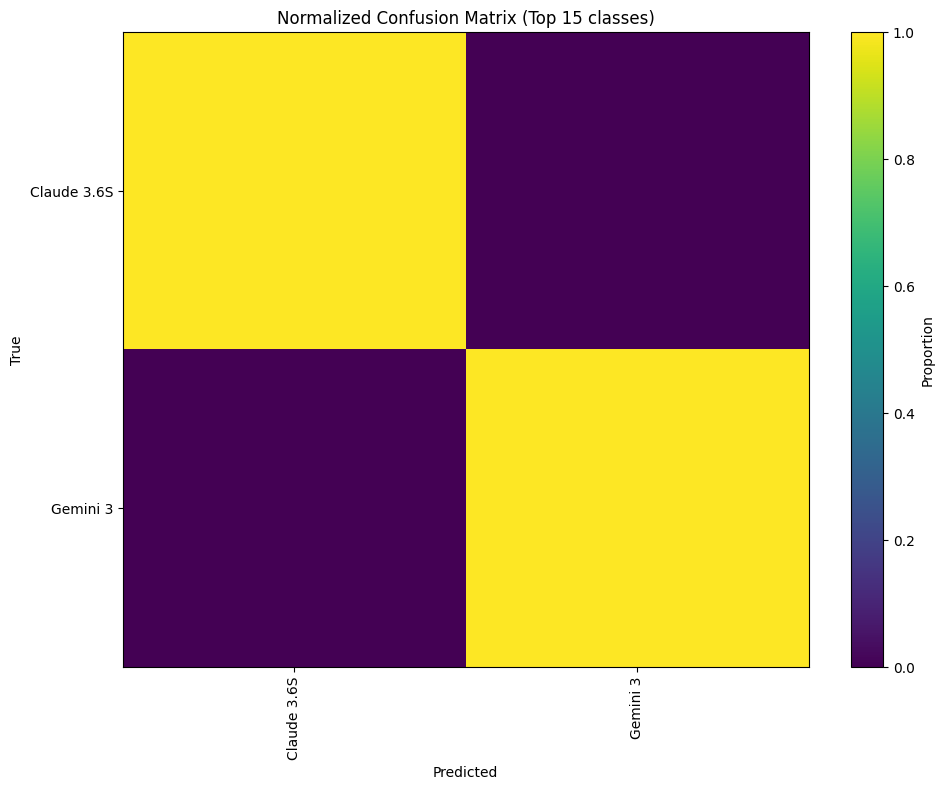

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Confusion matrix can be huge → show top-K most frequent true classes
K = 15
y_test_names = pd.Series([label_names[i] for i in y_test])
pred_names   = pd.Series([label_names[i] for i in pred])

top_classes = y_test_names.value_counts().head(K).index.tolist()

mask = y_test_names.isin(top_classes) & pred_names.isin(top_classes)
y_true_k = y_test_names[mask]
y_pred_k = pred_names[mask]

labels_k = top_classes
cm = confusion_matrix(y_true_k, y_pred_k, labels=labels_k)
cm_norm = cm / np.maximum(cm.sum(axis=1, keepdims=True), 1)  # row-normalized

plt.figure(figsize=(10, 8))
plt.imshow(cm_norm, aspect="auto")
plt.title(f"Normalized Confusion Matrix (Top {K} classes)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(labels_k)), labels_k, rotation=90)
plt.yticks(range(len(labels_k)), labels_k)
plt.colorbar(label="Proportion")
plt.tight_layout()
plt.show()

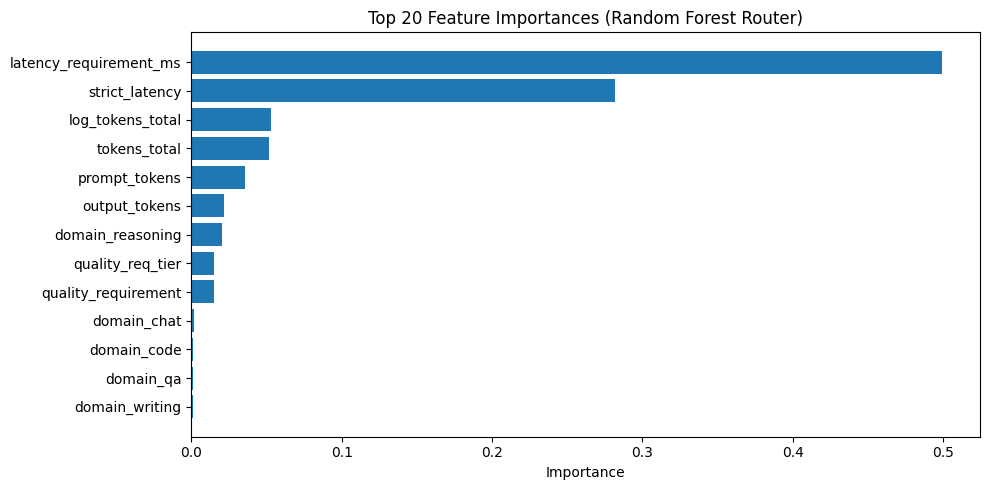

In [14]:
# Feature importance (Top 20) — RandomForest
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
importances = importances.sort_values(ascending=True)  # for horizontal plot

plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values)
plt.title("Top 20 Feature Importances (Random Forest Router)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### Apply Feasibility and Confidence Constraints

Enhance routing decisions by enforcing:

- Latency feasibility checks
- Confidence threshold fallback
- Cost-aware alternative selection

This improves real-world reliability.

In [26]:
# -------------------------
# Enhancement: feasibility-gated inference + confidence fallback
# -------------------------
# Gate: if predicted model is infeasible, choose cheapest feasible.
# If nothing feasible, choose fallback.
# Also: if confidence < threshold, choose cheapest feasible.
conf_thresh = 0.55

# Rebuild request slice for test set
idx = np.arange(len(X))
_, idx_test = train_test_split(idx, test_size=0.2, random_state=42, stratify=y_codes)
req_test = requests.iloc[idx_test].reset_index(drop=True)

pred_codes = pred
pred_models = np.array([label_names[c] for c in pred_codes])
conf = proba.max(axis=1)

def cheapest_feasible(row):
    tokens = row["tokens_total"]
    long_pen = 0.08 if tokens > 4000 else 0.0
    feas = []
    for m in models:
        base = mp[m]["base_latency_ms"]
        per  = mp[m]["per_token_ms"]
        cpt  = mp[m]["cost_per_token"]
        qn   = mp[m]["quality_score_norm"]
        pred_lat = (base + per * tokens) * 1.25
        pred_q = np.clip(qn - row["domain_penalty"] - long_pen, 0, 1)
        pred_c = cpt * tokens
        if (pred_lat <= row["latency_requirement_ms"]) and (pred_q >= row["quality_requirement"]):
            feas.append((pred_c, m))
    return sorted(feas)[0][1] if feas else fallback_model

# Apply gating
gated_models = []
for i in range(len(req_test)):
    if conf[i] < conf_thresh:
        gated_models.append(cheapest_feasible(req_test.loc[i]))
    else:
        # check feasibility for predicted model; if infeasible => cheapest feasible
        m = pred_models[i]
        row = req_test.loc[i]
        tokens = row["tokens_total"]
        long_pen = 0.08 if tokens > 4000 else 0.0
        base = mp[m]["base_latency_ms"]
        per  = mp[m]["per_token_ms"]
        qn   = mp[m]["quality_score_norm"]
        pred_lat = (base + per * tokens) * 1.25
        pred_q = np.clip(qn - row["domain_penalty"] - long_pen, 0, 1)
        if (pred_lat <= row["latency_requirement_ms"]) and (pred_q >= row["quality_requirement"]):
            gated_models.append(m)
        else:
            gated_models.append(cheapest_feasible(row))

gated_models = np.array(gated_models)


### Evaluate Routing Performance

Compare routing strategies based on:

- Total cost
- SLA compliance
- Feasibility satisfaction

Evaluate ungated model, gated model, and baseline policies.

In [27]:
# -------------------------
# Evaluate cost + SLA for ungated vs gated vs baselines
# -------------------------
def eval_policy(chosen_models, df_req):
    base = np.array([mp[m]["base_latency_ms"] for m in chosen_models])
    per  = np.array([mp[m]["per_token_ms"] for m in chosen_models])
    cpt  = np.array([mp[m]["cost_per_token"] for m in chosen_models])
    qn   = np.array([mp[m]["quality_score_norm"] for m in chosen_models])

    tokens = df_req["tokens_total"].values
    lat_req = df_req["latency_requirement_ms"].values
    q_req = df_req["quality_requirement"].values
    dom_pen = df_req["domain_penalty"].values
    long_pen = (tokens > 4000).astype(float) * 0.08

    pred_lat = (base + per * tokens) * 1.25
    pred_q = np.clip(qn - dom_pen - long_pen, 0, 1)
    pred_cost = cpt * tokens
    feasible = (pred_lat <= lat_req) & (pred_q >= q_req)

    return {
        "avg_cost": float(pred_cost.mean()),
        "sla_rate": float(feasible.mean()),
        "p95_latency_ms": float(np.percentile(pred_lat, 95)),
        "avg_quality": float(pred_q.mean()),
        "fallback_rate": float((chosen_models == fallback_model).mean())
    }

cheapest_model = profiles.sort_values("cost_per_token").iloc[0]["Model"]
bestq_model = profiles.sort_values("quality_score_norm", ascending=False).iloc[0]["Model"]

res_ungated = eval_policy(pred_models[:len(req_test)], req_test)
res_gated   = eval_policy(gated_models, req_test)
res_cheapest= eval_policy(np.array([cheapest_model]*len(req_test)), req_test)
res_bestq   = eval_policy(np.array([bestq_model]*len(req_test)), req_test)

summary = pd.DataFrame([
    {"policy":"router_raw", **res_ungated},
    {"policy":"router_gated_conf", **res_gated},
    {"policy":"always_cheapest", **res_cheapest},
    {"policy":"always_best_quality", **res_bestq},
])
display(summary)

# -------------------------
# Save artifacts
# -------------------------
requests.to_csv("synthetic_requests_labeled_v2.csv", index=False)
joblib.dump(rf, "rf_router_v2.joblib")

!aws s3 cp synthetic_requests_labeled_v2.csv s3://{bucket}/processed/synthetic_requests_labeled_v2.csv
!aws s3 cp rf_router_v2.joblib s3://{bucket}/models/rf_router_v2.joblib

print("Saved v2 dataset + model")

,policy,avg_cost,sla_rate,p95_latency_ms,avg_quality,fallback_rate
0,router_raw,0.012610,0.815875,798.095375,0.896985,0.194625
1,router_gated_conf,0.012610,0.815875,798.095375,0.896976,0.194500
2,always_cheapest,0.007006,0.000000,643.993875,0.000000,0.000000
3,always_best_quality,0.012610,0.815875,798.095375,0.954002,1.000000


upload: ./synthetic_requests_labeled_v2.csv to s3://sagemaker-us-east-1-907086662522/processed/synthetic_requests_labeled_v2.csv
upload: ./rf_router_v2.joblib to s3://sagemaker-us-east-1-907086662522/models/rf_router_v2.joblib
Saved v2 dataset + model


### Summary

This notebook trained and evaluated a cost-aware model routing system using simulated request workloads and model capability profiles.

Results demonstrate how intelligent routing can reduce operational cost while maintaining performance requirements.
